In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scanpy anndata

In [3]:
import scanpy as sc
adata = sc.read_h5ad('/content/drive/My Drive/cleaned_processed_frogtail.h5ad')

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata.obs.head()

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3


In [5]:
adata.X #row: 13199 cell; column: 31535 genes

<13199x31535 sparse matrix of type '<class 'numpy.int64'>'
	with 29297098 stored elements in Compressed Sparse Row format>

In [6]:
!pip install scanpy[leiden] python-igraph louvain

Clustering Analysis:

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


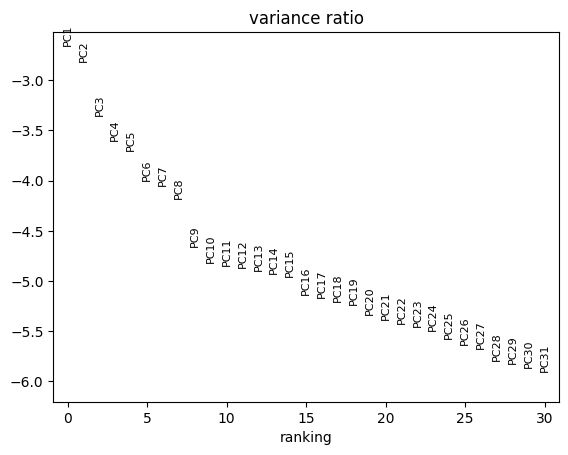

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score

adata = adata[adata.obs['DaysPostAmputation'] == 0]

# Log-normalize the data
hvg_adata = sc.pp.log1p(adata, copy=True)

# Select highly variable genes
sc.pp.highly_variable_genes(hvg_adata, n_top_genes=5000)

# Filter the data to keep only the highly variable genes
hvg_adata = hvg_adata[:, hvg_adata.var.highly_variable]

# Standard scaling of the data for clustering
sc.pp.scale(hvg_adata)

# PCA and variance ratio
sc.tl.pca(hvg_adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(hvg_adata, log=True)

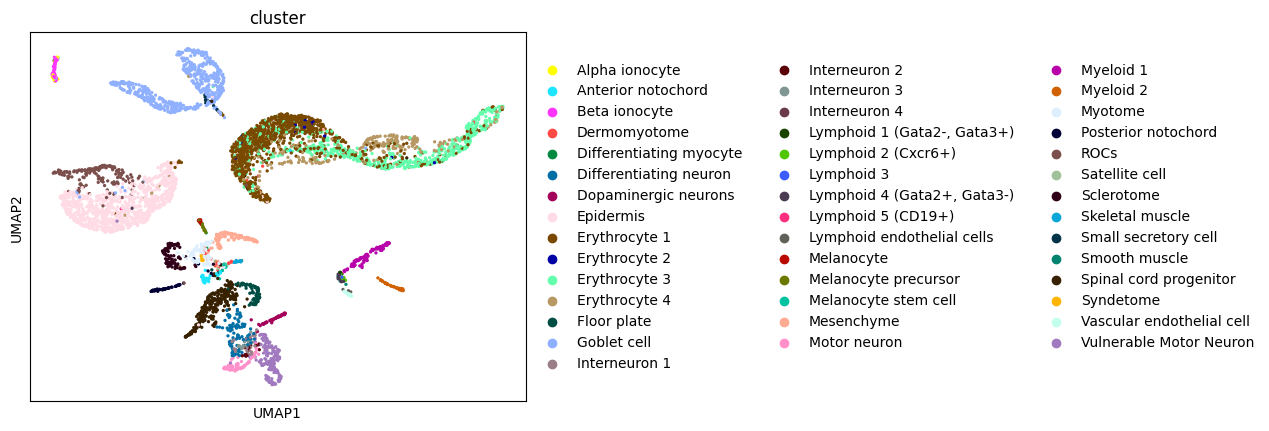

<ipython-input-8-a29308e997f7>:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(hvg_adata)


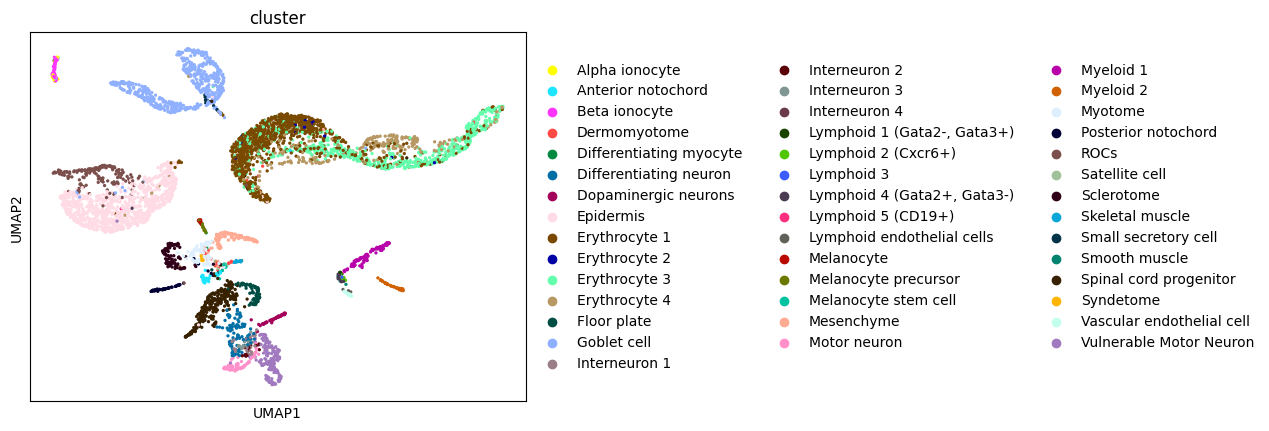

In [8]:
sc.pp.neighbors(hvg_adata, n_neighbors=15, n_pcs=20)

sc.tl.umap(hvg_adata)

# Louvain
sc.tl.louvain(hvg_adata)
sc.pl.umap(hvg_adata, color=['cluster'])

# Leiden
sc.tl.leiden(hvg_adata)
sc.pl.umap(hvg_adata, color=['cluster'])

In [9]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

pca_embedding = hvg_adata.obsm['X_pca']

silhouette_louvain = silhouette_score(pca_embedding, hvg_adata.obs['louvain'])
silhouette_leiden = silhouette_score(pca_embedding, hvg_adata.obs['leiden'])

print(f'Silhouette Score (Louvain): {silhouette_louvain}')
print(f'Silhouette Score (Leiden): {silhouette_leiden}')

Silhouette Score (Louvain): 0.16204409301280975
Silhouette Score (Leiden): 0.16021907329559326


In [10]:
# Bonus
from sklearn.metrics import davies_bouldin_score

dbi_louvain = davies_bouldin_score(pca_embedding, hvg_adata.obs['louvain'])
dbi_leiden = davies_bouldin_score(pca_embedding, hvg_adata.obs['leiden'])

print(f'Davies-Bouldin Index (Louvain): {dbi_louvain}')
print(f'Davies-Bouldin Index (Leiden): {dbi_leiden}')

Davies-Bouldin Index (Louvain): 1.5605255207635764
Davies-Bouldin Index (Leiden): 1.6539000168232296


Marker Selection and Gene Analysis:

In [11]:
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests

<ipython-input-12-b22c50588cf1>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1500x600 with 0 Axes>

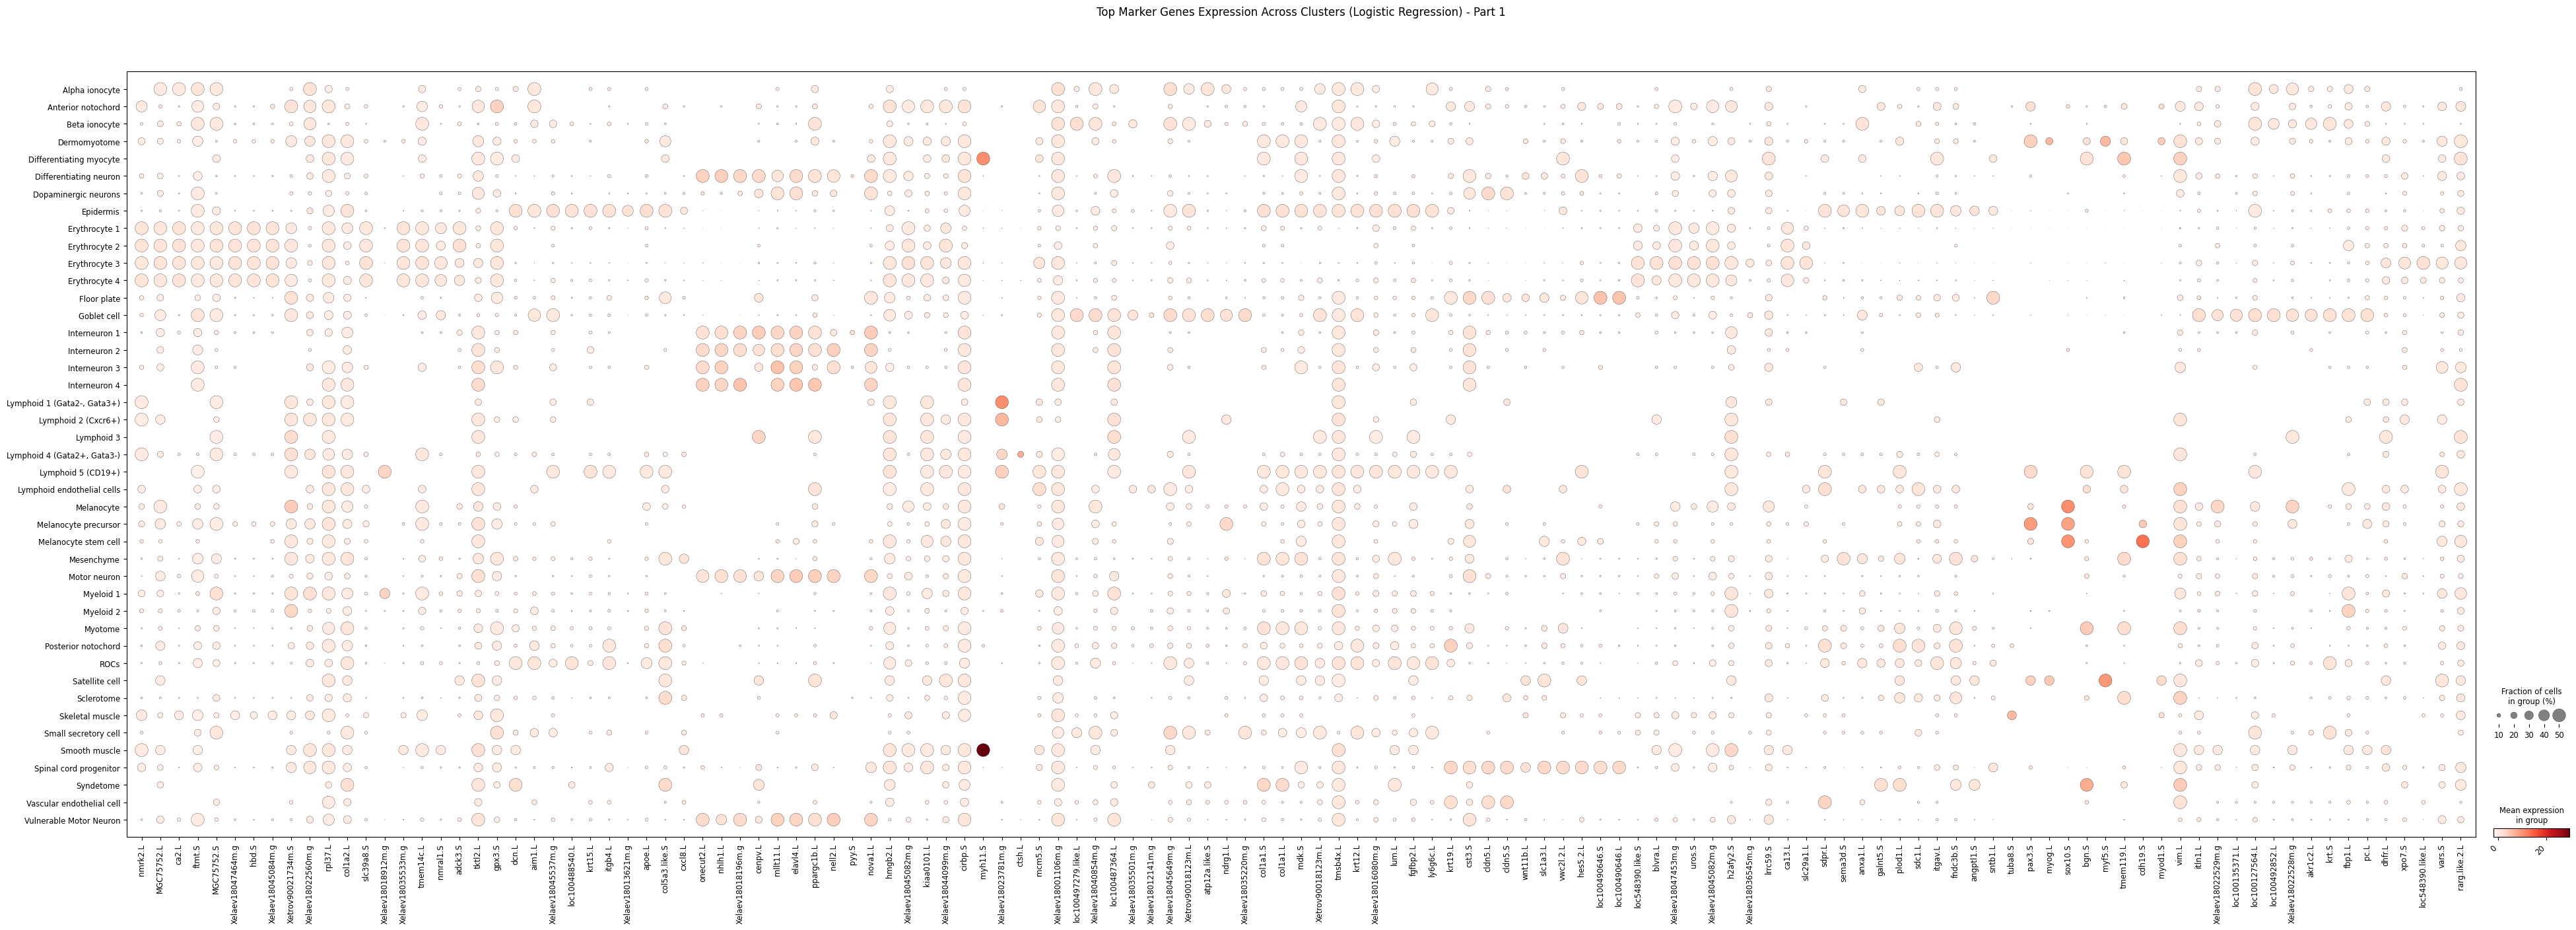

<ipython-input-12-b22c50588cf1>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1500x600 with 0 Axes>

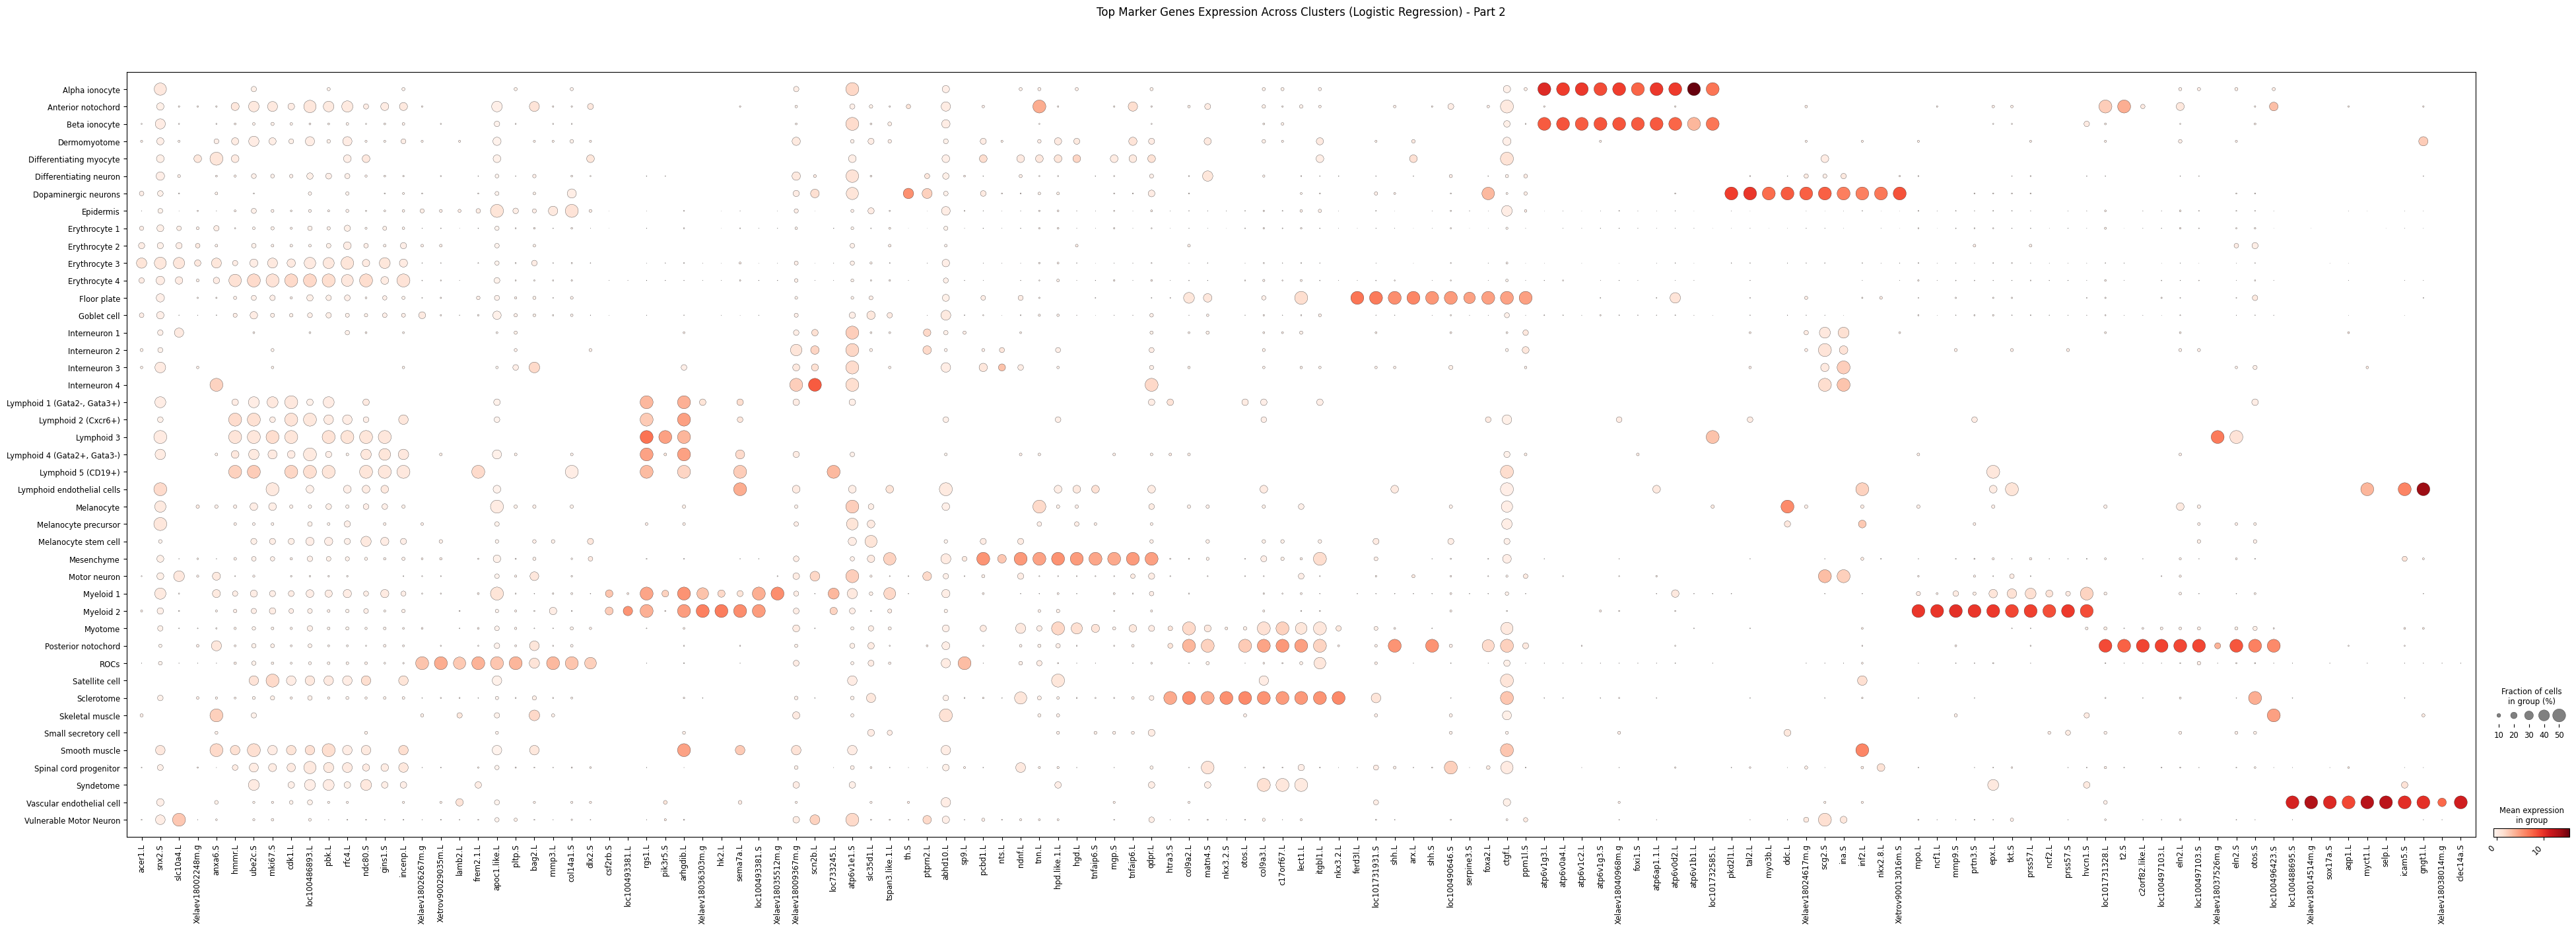

In [12]:
# Logistic regression

from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

X = hvg_adata.X
y = hvg_adata.obs['louvain']

y = pd.Categorical(y).codes

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X, y)

log_odds = logistic_model.coef_

top_genes_lr_indices = []
for i in range(log_odds.shape[0]):
    top_genes_lr_indices.append(np.argsort(-log_odds[i, :])[:10])

gene_names = hvg_adata.var.index
top_genes_lr_names = [[gene_names[idx] for idx in gene_list] for gene_list in top_genes_lr_indices]

top_genes_lr_df = pd.DataFrame(top_genes_lr_names, columns=[f'Gene_{i+1}' for i in range(10)])

import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

top_genes_lr_df = pd.DataFrame(top_genes_lr_names, columns=[f'Gene_{i+1}' for i in range(10)])

top_marker_genes_list = top_genes_lr_df.values.flatten().tolist()

mid_point = len(top_marker_genes_list) // 2
split_marker_genes_lists = [top_marker_genes_list[:mid_point], top_marker_genes_list[mid_point:]]

for i, sub_list in enumerate(split_marker_genes_lists):
    plt.figure(figsize=(15, 6))
    sc.pl.dotplot(
        hvg_adata,
        var_names=sub_list,
        groupby='cluster',
        dendrogram=False,
        title=f"Top Marker Genes Expression Across Clusters (Logistic Regression) - Part {i+1}",
        var_group_rotation=90,
        dot_max=0.5,
        show=False
    )
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


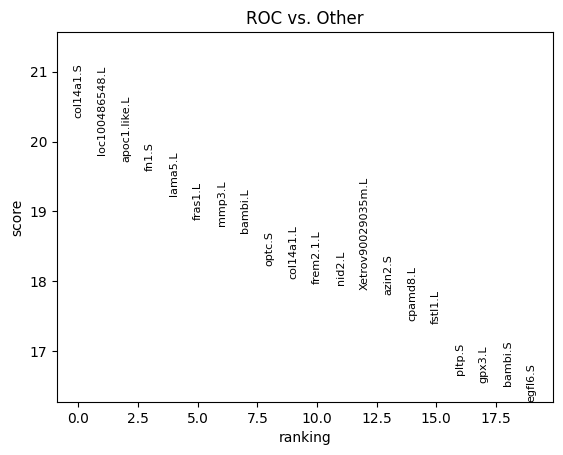

Top marker genes for ROC from DE analysis:
               ROC
0       col14a1.S
1  loc100486548.L
2    apoc1.like.L
3           fn1.S
4         lama5.L
5         fras1.L
6          mmp3.L
7         bambi.L
8          optc.S
9       col14a1.L


In [13]:
hvg_adata.obs['ROC_vs_rest'] = ['ROC' if cluster == 'ROCs' else 'Other' for cluster in hvg_adata.obs['cluster']]

# Wilcoxon rank-sum test
sc.tl.rank_genes_groups(hvg_adata, 'ROC_vs_rest', method='wilcoxon', reference='Other')
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False)

top_de_genes = pd.DataFrame(hvg_adata.uns['rank_genes_groups']['names']).head(10)
print("Top marker genes for ROC from DE analysis:\n", top_de_genes)

In [14]:
X = hvg_adata.X
y = hvg_adata.obs['ROC_vs_rest']
y = pd.Categorical(y).codes

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X, y)

log_odds = logistic_model.coef_

top_genes_lr_indices = np.argsort(-log_odds[0, :])[:10]
gene_names = hvg_adata.var.index

top_genes_lr_names = [gene_names[idx] for idx in top_genes_lr_indices]
print("Top marker genes for ROC from Logistic Regression analysis:\n", top_genes_lr_names)

Top marker genes for ROC from Logistic Regression analysis:
 ['lpar3.L', 'cdc42se2.like.2.S', 'Xetrov90029035m.L', 'bmp2.L', 'pltp.S', 'Xelaev18047608m.g', 'sp9.L', 'wnt5a.S', 'nid2.L', 'cpa6.L']


In [19]:
top_de_genes = pd.DataFrame(hvg_adata.uns['rank_genes_groups']['names']).iloc[:, 0].head(1000).tolist()

top_genes_lr_indices = np.argsort(-log_odds[0, :])[:1000]
gene_names = hvg_adata.var.index
top_genes_lr_names = [gene_names[idx] for idx in top_genes_lr_indices]

# Comparison of genes from both methods
common_genes = set(top_de_genes).intersection(top_genes_lr_names)
print("\nCommon marker genes from both methods:\n", common_genes)


Common marker genes from both methods:
 {'tsku.L', 'Xelaev18043128m.g', 'fbp1.L', 'wasl.S', 'pdia6.S', 'smox.S', 'tmed9.L', 'fam46a.L', 'kitlg.S', 'bambi.L', 'prdm1.S', 'enpp2.L', 'Xelaev18014807m.g', 'hpgds.S', 'serpinf1.L', 'tpd52.S', 'kcnk1.L', 'gata2.L', 'rassf10.L', 'fabp3.S', 'fbxw7.like.L', 'tinagl1.S', 'dusp6.L', 'azin2.S', 'app.L', 'pnp.L', 'gng7.S', 'lrrc59.S', 'Xelaev18037442m.g', 'loc100497659.S', 'fras1.L', 'frem1.L', 'colgalt1.L', 'ccdc3.L', 'hoxa9.L', 'bmp5.L', 'has2.L', 'Xelaev18040375m.g', 'sostdc1.L', 'tpi1.S', 'sdc1.L', 'rgs16.L', 'krt12.S', 'fosl1.L', 'pck1.L', 'net1.S', 'atp8b1.S', 'spock3.S', 'cyp26c1.L', 'fbn3.L', 'col5a2.L', 'nkain1.L', 'atp10d.L', 'acvr1.L', 'palm3.like.L', 'galnt5.S', 'loc100490088.L', 'wnt5a.S', 'Xelaev18044179m.g', 'cldn7.S', 'lrp1.L', 'anxa2.S', 'loc100170576.L', 'megf6.S', 'ecm2.1.L', 'ets2.L', 'kcnj2.L', 'rgs10.S', 'dnajb11.S', 'herpud1.S', 'slc37a2.L', 'slc25a5.L', 'fabp3.L', 'ppp1r13l.L', 'Xelaev18034615m.g', 'col27a1.S', 'Xelaev180092

In [16]:
# Compare with Supplementary Table 3
import pandas as pd

excel_file_path = '/content/drive/My Drive/aav9996_tables3.xlsx'
sheets = pd.ExcelFile(excel_file_path).sheet_names

supplementary_genes = set()
for sheet in sheets:
    sheet_data = pd.read_excel(excel_file_path, sheet_name=sheet, header=None, usecols=[0])
    supplementary_genes.update(sheet_data[0].dropna().values)

top_genes_lr_union = set(top_genes_lr_names)
top_genes_de = set(top_de_genes)

combined_top_genes = top_genes_lr_union.union(top_genes_de)

common_with_supp = combined_top_genes.intersection(supplementary_genes)
print(f"Common genes with Supplementary Table 3: {common_with_supp}")

num_common_with_supp = len(common_with_supp)
print(f"Number of common genes with Supplementary Table 3: {num_common_with_supp}")

Common genes with Supplementary Table 3: {'fgfr4.S', 'cks1b.L', 'jag1.L', 'mcm4.L', 'birc5.1.L', 'prim1.S', 'fgf9.S', 'uhrf1.L', 'gtse1.L', 'bmp4.S', 'tgfb1.L', 'cdc20.L', 'fgfr4.L', 'dll1.L', 'fzd10.L', 'wnt3a.S', 'slbp.S', 'cenpe.L', 'slbp.L', 'hmgb2.L', 'fgf7.L', 'tgfb2.L', 'fgf9.L', 'tyms.L', 'fgf7.S', 'kif11.S', 'wnt5a.S', 'apcdd1.L', 'tgfb1.S', 'bmp6.S', 'bmp2.S', 'lrp1.L', 'bmp4.L', 'notch1.S', 'fgf3.S', 'wnt7b.L', 'bmp2.L', 'nasp.L', 'ube2c.L', 'wnt4.L', 'lrp1.S', 'bmp5.L', 'jag2.L'}
Number of common genes with Supplementary Table 3: 43


In [17]:
# Bonus
!pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 10.8 MB/s eta 0:00:00


In [19]:
import gseapy as gp

# Combine top genes from both methods (Logistic Regression and Wilcoxon rank-sum test)
combined_top_genes_list = list(combined_top_genes)  # Convert set to list for input to gseapy

# Perform GO analysis using a custom gene set library if available
go_results = gp.enrichr(gene_list=combined_top_genes_list,
                        gene_sets='path_to_frog_gene_set_library.gmt',  # Custom gene set in GMT format
                        organism='Frog',  # Specify organism if supported
                        outdir='GO_analysis',  # Directory where the results will be saved
                        cutoff=0.05)  # P-value cutoff for significance

print("Top GO Biological Processes:\n", go_results.results.head(10))